In [2]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# For text processing
from sklearn.feature_extraction.text import TfidfVectorizer
# For dimensionality reduction
from sklearn.decomposition import PCA
# For clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
# For handling warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
column_n = ['news_id', 'category', 'subacategory', 'Title', 'Abstract', 'url', 'TitleEnt', 'AbstractEnt']
column_b = ['ImpressionId', 'user_id', 'timestamps', 'history', 'impressions']
news_df  = pd.read_csv('data/news.tsv', sep='\t', header=None, names=column_n)
behaviors_df= pd.read_csv('data/behaviors.tsv', sep='\t', header=None, names=column_b)

In [4]:
news_df.head(2)

,news_id,category,subacategory,Title,Abstract,url,TitleEnt,AbstractEnt
0,N55528,lifestyle,lifestyleroyals,"The Brands Queen Elizabeth, Prince Charles, an...","Shop the notebooks, jackets, and more that the...",https://assets.msn.com/labs/mind/AAGH0ET.html,"[{""Label"": ""Prince Philip, Duke of Edinburgh"",...",[]
1,N19639,health,weightloss,50 Worst Habits For Belly Fat,These seemingly harmless habits are holding yo...,https://assets.msn.com/labs/mind/AAB19MK.html,"[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik...","[{""Label"": ""Adipose tissue"", ""Type"": ""C"", ""Wik..."


In [6]:
behaviors_df.head(2)

,ImpressionId,user_id,timestamps,history,impressions
0,1,U13740,11/11/2019 9:05:58 AM,N55189 N42782 N34694 N45794 N18445 N63302 N104...,N55689-1 N35729-0
1,2,U91836,11/12/2019 6:11:30 PM,N31739 N6072 N63045 N23979 N35656 N43353 N8129...,N20678-0 N39317-0 N58114-0 N20495-0 N42977-0 N...


In [124]:
behaviors_df = behaviors_df.sample(frac=0.1, random_state=42)

# Feature Extraction

In [128]:
# Fill NaN values in 'Title' and 'Abstract' with empty strings
news_df['Title'] = news_df['Title'].fillna('')
news_df['Abstract'] = news_df['Abstract'].fillna('')
behaviors_df['history'] = behaviors_df['history'].fillna('')

In [130]:
#Extract User Histories
# Split the 'history' string into a list of news_ids
behaviors_df['history_list'] = behaviors_df['history'].apply(lambda x: x.split(' ') if x != '' else [])


### Create a News ID to Category Mapping

In [133]:
# Create a mapping from news_id to category
news_category_map = news_df.set_index('news_id')['category'].to_dict()

### Build User-Category Interaction Matrix

In [136]:
from tqdm import tqdm
from collections import Counter


# Initialize a list to store user-category interactions
user_category_data = []

# Iterate over each user's history
for idx, row in tqdm(behaviors_df.iterrows(), total=behaviors_df.shape[0]):
    user_id = row['user_id']
    history = row['history_list']
    categories = [news_category_map.get(news_id, 'Unknown') for news_id in history]
    category_counts = Counter(categories)
    category_counts['user_id'] = user_id
    user_category_data.append(category_counts)

# Create DataFrame
user_category_df = pd.DataFrame(user_category_data)
user_category_df = user_category_df.fillna(0)


100%|██████████| 15696/15696 [00:01<00:00, 12593.70it/s]


In [138]:
user_category_df = user_category_df.head(1000)
user_category_df

,foodanddrink,tv,lifestyle,news,sports,entertainment,movies,health,autos,travel,user_id,finance,weather,music,video,kids,middleeast
0,5.0,2.0,9.0,8.0,7.0,5.0,2.0,3.0,1.0,1.0,U46778,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,U19033,1.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,3.0,U30,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,7.0,0.0,0.0,1.0,1.0,1.0,0.0,U76070,5.0,1.0,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,8.0,0.0,0.0,0.0,0.0,0.0,1.0,U54617,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,U79754,0.0,0.0,0.0,0.0,0.0,0.0
996,2.0,10.0,8.0,19.0,25.0,2.0,2.0,3.0,0.0,2.0,U49232,3.0,1.0,4.0,1.0,0.0,0.0
997,1.0,1.0,0.0,5.0,2.0,0.0,0.0,0.0,1.0,0.0,U40432,0.0,1.0,0.0,0.0,0.0,0.0
998,0.0,1.0,4.0,58.0,37.0,0.0,0.0,0.0,2.0,4.0,U57214,2.0,0.0,0.0,1.0,0.0,0.0


### Preparing Data for PCA

#### Separate Features and Labels

In [142]:
# Separate user_id from features
user_ids = user_category_df['user_id']
features = user_category_df.drop('user_id', axis=1)

#### Standardize the Data

In [145]:
# Standardize features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)


### Applying PCA

In [148]:
# Initialize PCA
# Initialize PCA to reduce to 2 components for visualization
pca = PCA(n_components=2)

In [150]:
# Fit and Transform the Data
principal_components = pca.fit_transform(features_scaled)

In [152]:
# Create a DataFrame with Principal Components
# Create DataFrame
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['user_id'] = user_ids.values

In [154]:
pca_df

,PC1,PC2,user_id
0,1.054985,-0.876470,U46778
1,-1.750471,0.163643,U19033
2,-1.130455,0.880688,U30
3,-0.629195,0.494688,U76070
4,-1.489035,0.341774,U54617
...,...,...,...
995,-1.606376,-0.243524,U79754
996,3.302438,-1.391872,U49232
997,-1.263533,0.580835,U40432
998,1.638011,1.774172,U57214


In [156]:
# Save the PCA DataFrame with cluster labels to CSV
pca_df.to_csv('pca_df.csv', index=False)

### Visualizing the Results

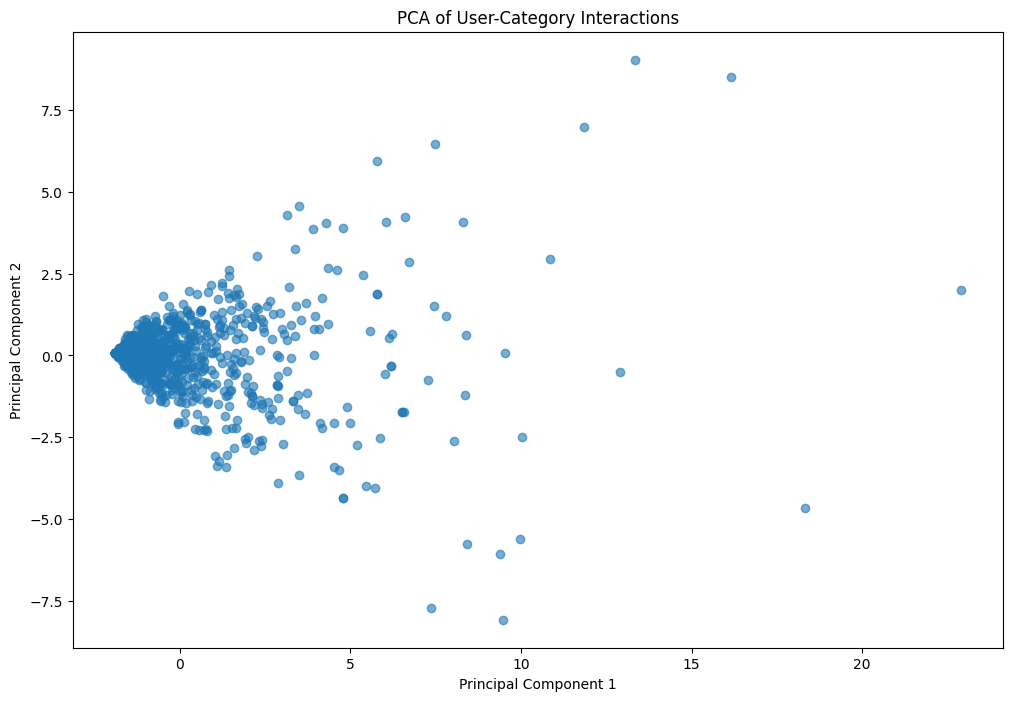

In [159]:
# Plot the Principal Components
plt.figure(figsize=(12, 8))
plt.scatter(pca_df['PC1'], pca_df['PC2'],cmap='plasma', alpha=0.6)
plt.title('PCA of User-Category Interactions')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

#### Analyze Variance Explained

### Interpreting the Results

In [163]:
# Examine Clusters
loadings = pd.DataFrame(pca.components_.T, columns=['PC1', 'PC2'], index=features.columns)
print(loadings)

                    PC1       PC2
foodanddrink   0.238223  0.185499
tv             0.313313 -0.338525
lifestyle      0.324399 -0.071061
news           0.290809  0.136219
sports         0.227597  0.075140
entertainment  0.261428 -0.389033
movies         0.288504 -0.341986
health         0.281730  0.119280
autos          0.236915  0.251840
travel         0.274695  0.356472
finance        0.293989  0.229264
weather        0.196830  0.345829
music          0.270392 -0.414653
video          0.206542  0.067961
kids          -0.000000  0.000000
middleeast    -0.000000  0.000000


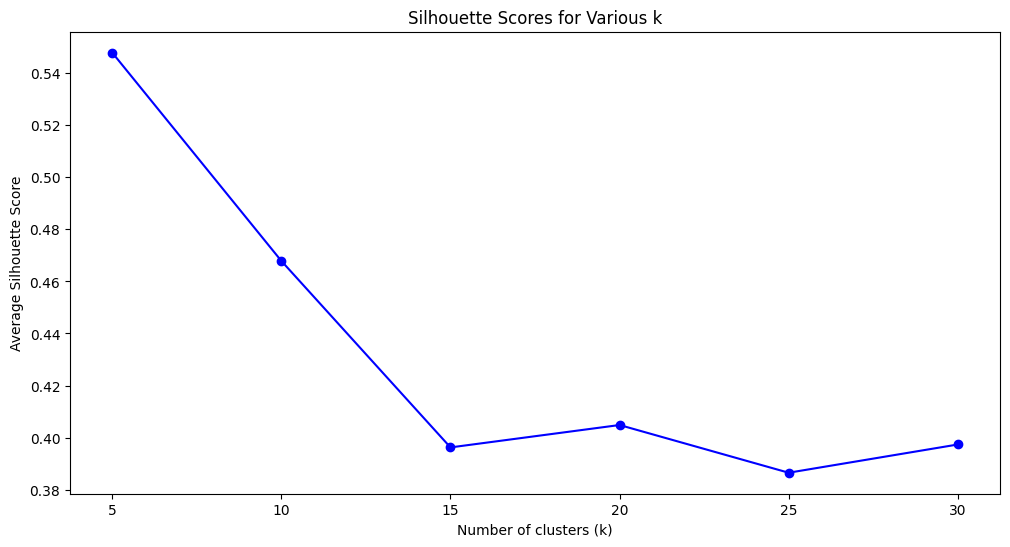

In [181]:
from sklearn.metrics import silhouette_score

# Define the range of k values to test (start from 2 since silhouette score requires at least 2 clusters)
k_values = range(5, 35 ,5)

# List to store silhouette scores
silhouette_scores = []

# Calculate silhouette scores for each k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_labels = kmeans.fit_predict(pca_df[['PC1', 'PC2']])
    silhouette_avg = silhouette_score(pca_df[['PC1', 'PC2']], cluster_labels)
    silhouette_scores.append(silhouette_avg)

# Plot the Silhouette Scores
plt.figure(figsize=(12, 6))
plt.plot(k_values, silhouette_scores, 'bo-')
plt.title('Silhouette Scores for Various k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Average Silhouette Score')
plt.xticks(k_values)
plt.show()



#### . Additional Analysis
##### Clustering Users

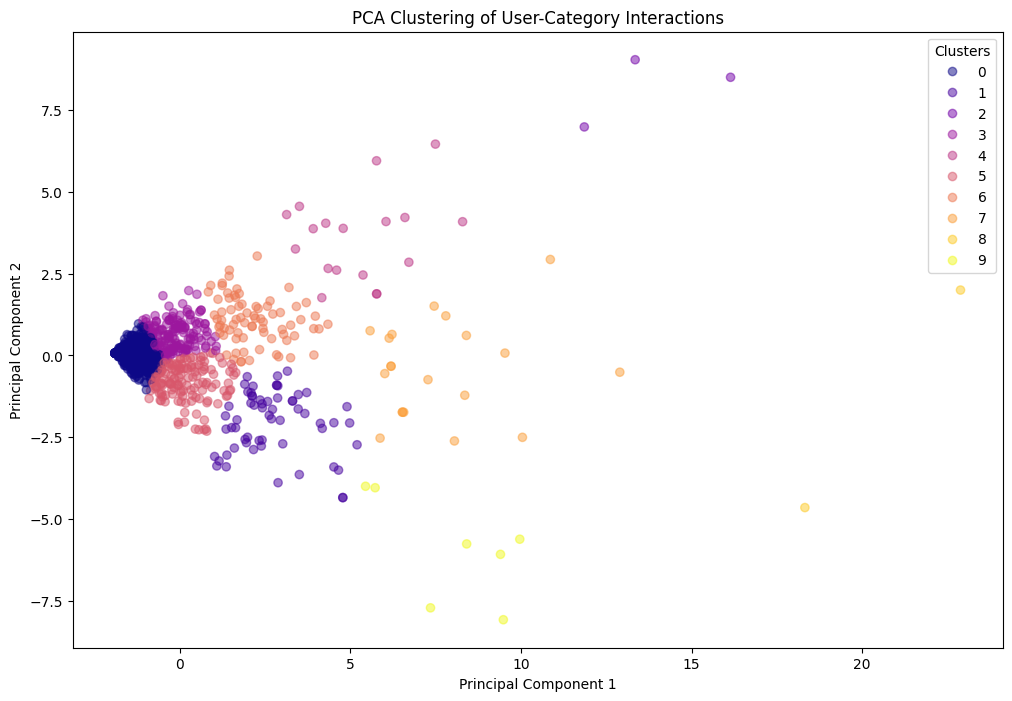

In [184]:
from sklearn.cluster import KMeans

# Determine the optimal number of clusters (optional step)
# Use methods like Elbow Method or Silhouette Score

# Apply KMeans clustering
kmeans = KMeans(n_clusters=10)
pca_df['Cluster'] = kmeans.fit_predict(pca_df[['PC1', 'PC2']])

# Plot clusters
plt.figure(figsize=(12, 8))
scatter = plt.scatter(pca_df['PC1'], pca_df['PC2'], c=pca_df['Cluster'], cmap='plasma', alpha=0.5)
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.title('PCA Clustering of User-Category Interactions')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7fd04855b160>
Traceback (most recent call last):
  File "/home/yuvisa/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/yuvisa/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
  File "/home/yuvisa/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
  File "/home/yuvisa/anaconda3/lib/python3.9/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
AttributeError: 'NoneType' object has no attribute 'split'
Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.mat

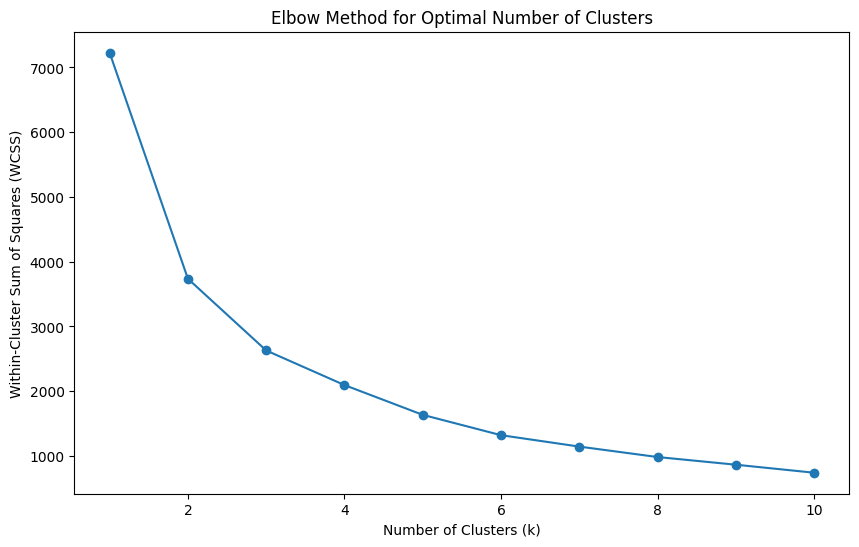

In [186]:
# Define the range for the number of clusters
k_values = range(1, 11)
wcss = []

# Calculate WCSS for each k
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(pca_df[['PC1', 'PC2']])
    wcss.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(k_values, wcss, marker='o')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.show()

